In [70]:
# Packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import openpyxl
plt.style.use('seaborn-poster')

## Import data

In [71]:
# Import the income statement
income_statement = pd.read_excel('../Financial Statements Data.xlsx', sheet_name=0, header=4, index_col=0)
income_statement.drop(income_statement.loc[:, 'Unnamed: 7':'Unnamed: 9'].columns, axis=1, inplace=True)
income_statement.dropna(inplace=True)
income_statement = income_statement.astype('float64')
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Import the Balance Sheet
balance_sheet = pd.read_excel('../Financial Statements Data.xlsx', sheet_name=1, header=3, index_col=0)
balance_sheet.drop(balance_sheet.loc[:, 'Unnamed: 7':'Unnamed: 11'].columns, axis=1, inplace=True)
balance_sheet.drop(balance_sheet.iloc[[1, 11, 18, 20, 21, 23, 27, 34, 42, 44, 45]].index, inplace=True)
balance_sheet.fillna(0, inplace=True)

years = np.asarray(balance_sheet.columns)

In [ ]:
# income_statement
balance_sheet

# Capital structure

In [72]:
# Liabilities
short_term_debt = balance_sheet.loc['Short-term borrowings':'Other liabilities (for 2017-2015)'].copy()
long_term_debt = balance_sheet.loc['Long-term borrowings':'Purchase commitments for minority interests\' shares'].copy()

debt = pd.concat([short_term_debt, long_term_debt], axis=0)
# Equity
equity = balance_sheet.loc[['Equity, Group share', 'Minority interests']].copy()

liabilities = pd.concat([debt, equity], axis=0)
# Assets
current_assets = balance_sheet.loc['Inventories and work in progress':'Cash and cash equivalents'].copy()
noncurrent_assets = balance_sheet.loc['Brands and other intangible assets':'Deferred tax (assets)'].copy()

assets = pd.concat([current_assets, noncurrent_assets], axis=0)

In [73]:
total_short_term_debt = short_term_debt.sum(axis=0)
total_long_term_debt = long_term_debt.sum(axis=0)
total_debt = total_short_term_debt.add(total_long_term_debt)

total_equity = np.sum(equity, axis=0)

total_liabilities = np.sum((total_debt, total_equity), axis=0)
total_liabilities = total_debt.add(total_equity)

total_current_assets = np.sum(current_assets, axis=0)
total_noncurrent_assets = np.sum(noncurrent_assets, axis=0)

total_assets = total_current_assets.add(total_noncurrent_assets)

## Computing ratios

In [74]:
debt_ratio = total_debt / total_assets
debt_to_equity = total_debt / total_equity
long_term_debt_to_capitalization = total_long_term_debt / np.sum((total_liabilities, total_equity), axis=0)

In [75]:
print(np.round(debt_ratio, 3))
print(np.round(debt_to_equity, 3))
print(np.round(long_term_debt_to_capitalization, 3))

2020   0.643
2019   0.602
2018   0.543
2017   0.559
2016   0.532
2015   0.552
dtype: float64
2020   1.799
2019   1.515
2018   1.188
2017   1.265
2016   1.137
2015   1.233
dtype: float64
2020   0.302
2019   0.263
2018   0.217
2017   0.236
2016   0.216
2015   0.229
dtype: float64


In [76]:
# Data from other sources
# Apparel And Other Finished Products Made From Fabrics And Similar Materials Industry median ratios
years_median = [2019, 2018, 2017, 2016, 2015]

median_debt_ratio = pd.Series([0.71, 0.52, 0.47, 0.54, 0.47], index=years_median)
median_debt_to_equity_ratio = pd.Series([1.12, 0.86, 0.74, 0.80, 0.50], index=years_median)
median_interest_coverage_ratio = pd.Series([6.28, 8.45, 7.79, 7.76, 7.18], index=years_median)

In [77]:
def plot_ratio(ratios, ratio_name, median=None):
    years = ratios.index.values
    plt.plot(years, ratios, color='midnightblue', label='LVMH')
    plt.plot(years, ratios, 'ro', markersize=7)

    y_max = ratios.max()

    if median is not None:
        median_years = median.index.values
        plt.plot(median_years, median, color='seagreen', alpha=0.5, label='Industry average')
        plt.plot(median_years, median, 'go', markersize=5)
        if median.max() > y_max: y_max = median.max()

    plt.xlabel('year')
    plt.ylabel(ratio_name)
    # TODO: define the step in yticks dynamically (maybe set 10 ticks)
    plt.yticks(np.arange(0, (y_max + y_max*0.2), step=0.1))

    plt.title('Evolution of {} from {} to {}'.format(ratio_name, min(years), max(years)))
    plt.legend(frameon=True, edgecolor='black')

    plt.savefig(fname='./plots/plot_{}'.format(ratio_name), format='png')
    plt.show()

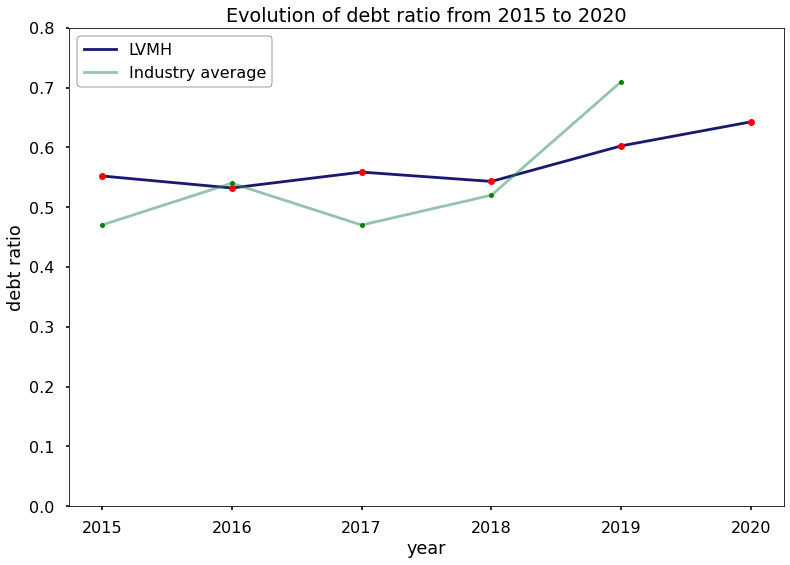

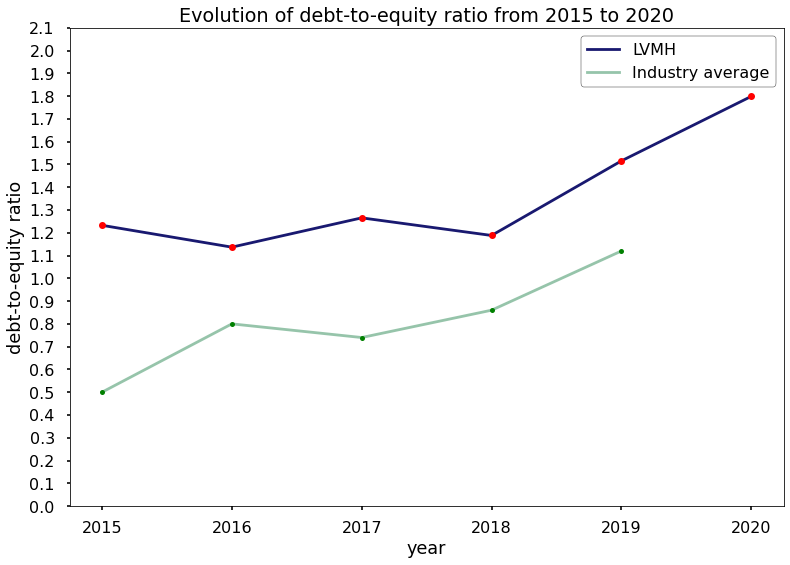

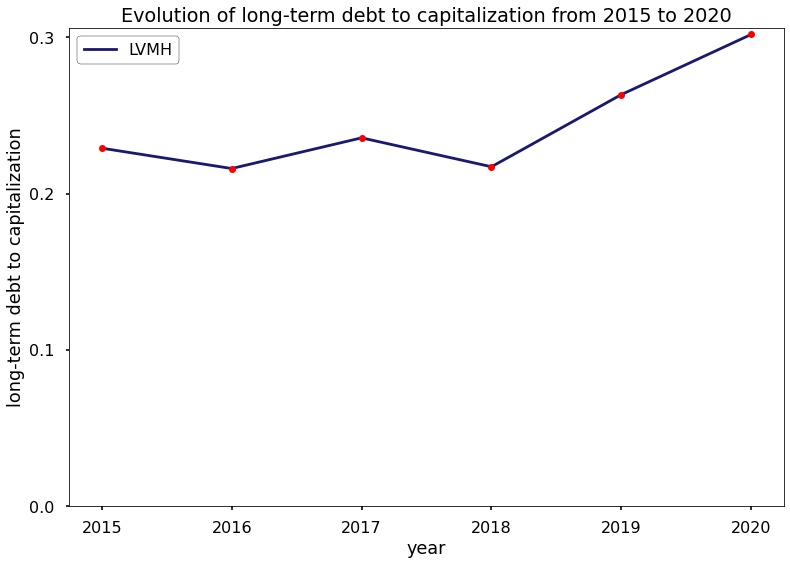

In [78]:
# Plot the capital structure ratios
plot_ratio(debt_ratio, ratio_name='debt ratio', median=median_debt_ratio)
plot_ratio(debt_to_equity, ratio_name='debt-to-equity ratio', median=median_debt_to_equity_ratio)
plot_ratio(long_term_debt_to_capitalization, ratio_name='long-term debt to capitalization')


## Earning power

In [79]:
net_income = income_statement.loc['Net profit, Group share'].copy()
interest = np.sum((income_statement.loc['Minority interests'], income_statement.loc['Cost of net financial debt']), axis=0)
taxes = income_statement.loc['Income taxes'].copy()
EBIT = net_income.add(-interest).add(-taxes)
FCBT = income_statement.loc['General and administrative expenses'].copy()

In [80]:
earnings_to_fixed_charges = EBIT.add(-FCBT) / (-(FCBT.add(interest)))
times_interest_earned_ratio = EBIT / (-interest)

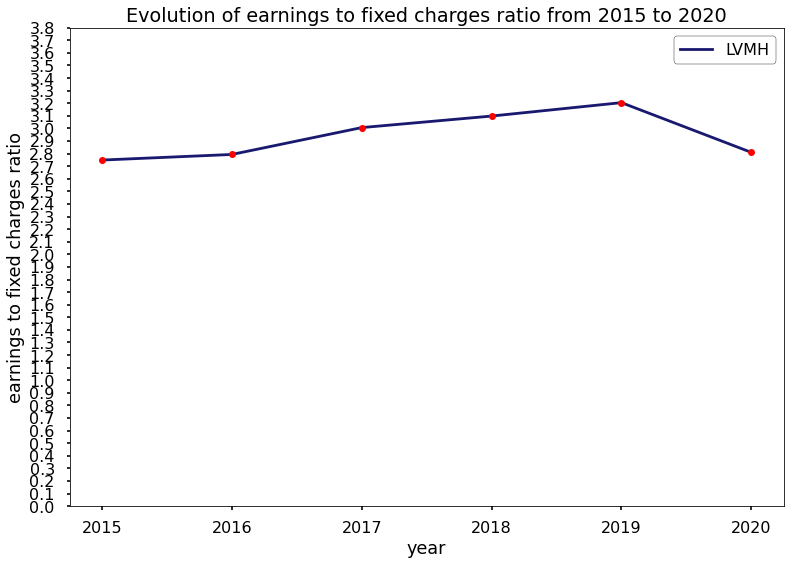

In [81]:
plot_ratio(earnings_to_fixed_charges, ratio_name='earnings to fixed charges ratio')
# plot_ratio(times_interest_earned_ratio, ratio_name='times interest earned ratio')

### Common-size analysis of the capital structure

In [82]:
common_size = balance_sheet.loc['LIABILITIES AND EQUITY':'Current liabilities'].copy()
total_capital = balance_sheet.loc['Total liabilities and equity'].copy()

common_size /= total_capital
# common_size

# Return on Invested Capital

## Return on Net Operating Asset (RNOA)

In [83]:
## Net Operating Assets (NOA)
operating_assets = assets.loc['Inventories and work in progress':'Investments in joint ventures and associates'].copy().drop('Income taxes (asset)').sum().sort_index()
operating_liabilities = balance_sheet.loc['Trade accounts payable':'Other liabilities (for 2017-2015)'].copy().append(balance_sheet.loc['Deferred tax (equity)'].copy()).sum(axis=0).sort_index()
NOA = operating_assets - operating_liabilities

avg_NOA = NOA.rolling(window=2).mean()
avg_NOA[2015] = NOA[2015]

In [84]:
## Net Operating Profit After tax (NOPAT)
sales = income_statement.loc['Revenue'].copy()
operating_expenses = -income_statement.loc['Marketing and selling expenses':'Income/(loss) from joint ventures and associates'].copy().append(income_statement.loc['Other operating income and expenses'].copy()).sum(axis=0)
eff_tax_rate = -income_statement.loc['Income taxes'].copy() / (income_statement.loc['Net profit, Group share'].copy() - income_statement.loc['Income taxes'].copy())

NOPAT = ((sales - operating_expenses) * (1 - eff_tax_rate)).sort_index()
RNOA = NOPAT / avg_NOA

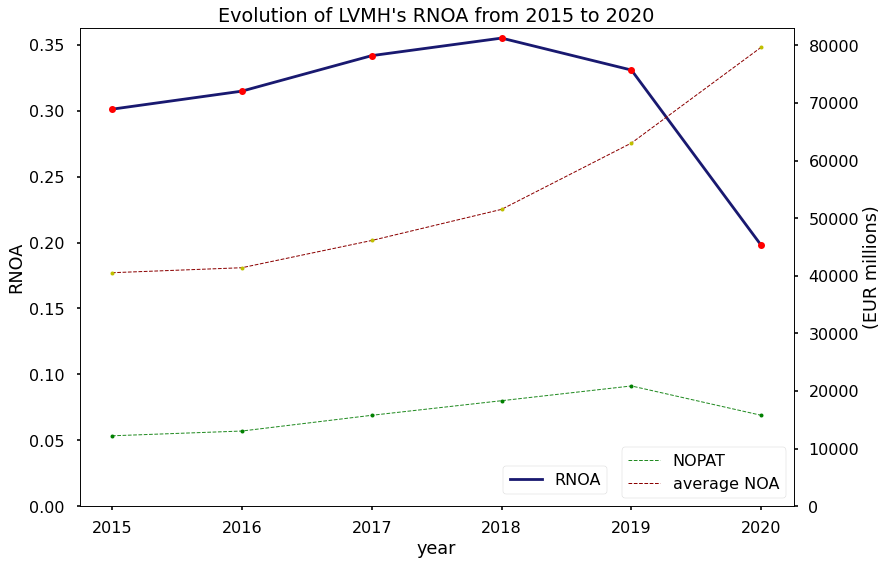

In [85]:
years.sort()
fig, ax1 = plt.subplots()

ax1.plot(years, RNOA, color='midnightblue', label='RNOA')
ax1.plot(years, RNOA, 'ro', markersize=7)

ax1.legend(loc='upper right', bbox_to_anchor=(0.75, 0.1))
ax1.set_yticks(np.arange(0, (RNOA.max() + RNOA.max() * 0.1), step=0.05))
ax1.set_xlabel('year')
ax1.set_ylabel('RNOA')

ax2 = ax1.twinx()
ax2.plot(years, NOPAT, linewidth=1, linestyle='dashed', color='forestgreen', label='NOPAT')
ax2.plot(years, NOPAT, 'go', markersize=4)
ax2.plot(years, avg_NOA, linewidth=1, linestyle='dashed', color='darkred', label='average NOA')
ax2.plot(years, avg_NOA, 'yo', markersize=4)

ax2.set_yticks(np.arange(0, (avg_NOA.max() + avg_NOA.max()*0.1), step=10000))
ax2.set_ylabel('(EUR millions)')
ax2.legend(loc='lower right', bbox_to_anchor=(1, 0))

plt.title('Evolution of LVMH\'s RNOA from {} to {}'.format(years.min(), years.max()))
# plt.savefig(fname='./plots/plot_RNOA', format='png')
plt.show()

### Disaggregating RNOA

In [86]:
sales = sales.sort_index()
NOP_margin = NOPAT / sales
NOA_turnover = sales / avg_NOA

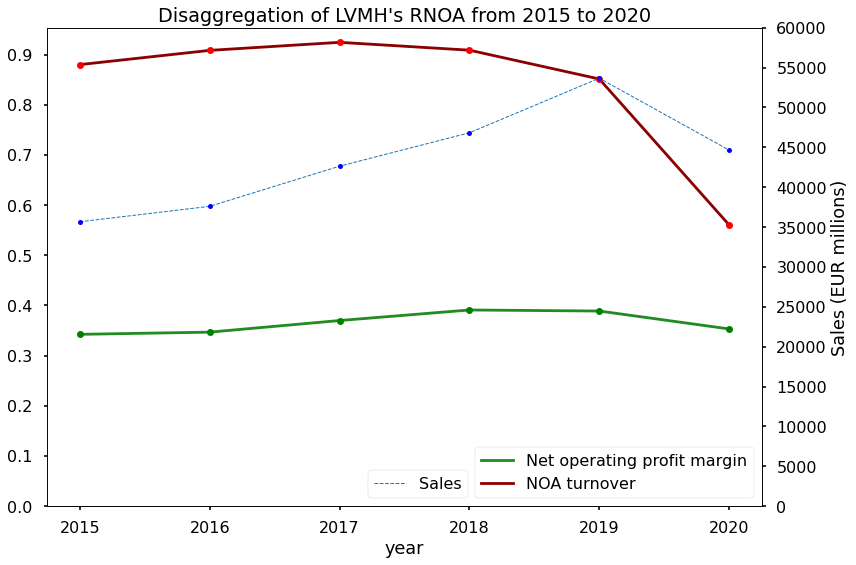

In [87]:
fig, ax1 = plt.subplots()

ax1.plot(years, NOP_margin, color='forestgreen', label='Net operating profit margin')
ax1.plot(years, NOP_margin, 'go', markersize=7)
ax1.plot(years, NOA_turnover, color='darkred', label='NOA turnover')
ax1.plot(years, NOA_turnover, 'ro', markersize=7)

ax1.set_yticks(np.arange(0, 1, step=0.1))
ax1.set_xlabel('year')
ax1.legend(loc='lower right')

ax2 = ax1.twinx()
ax2.plot(years, sales, linewidth=1, linestyle='dashed', label='Sales')
ax2.plot(years, sales, 'bo', markersize=5)

ax2.set_ylabel('Sales (EUR millions)')
ax2.set_yticks(np.arange(0, (sales.max() + sales.max()*0.2), step=5000))
ax2.legend(loc='lower right', bbox_to_anchor=(0.6, 0))

plt.title('Disaggregation of LVMH\'s RNOA from {} to {}'.format(years.min(), years.max()))
plt.savefig(fname='./plots/plot_Disagg-RNOA', format='png')
plt.show()

## Return on Common Equity (ROCE)

In [88]:
net_income = income_statement.loc['Net profit, Group share'].copy().sort_index()
common_equity = balance_sheet.loc['Equity'].copy().sort_index()

ROCE = net_income / common_equity

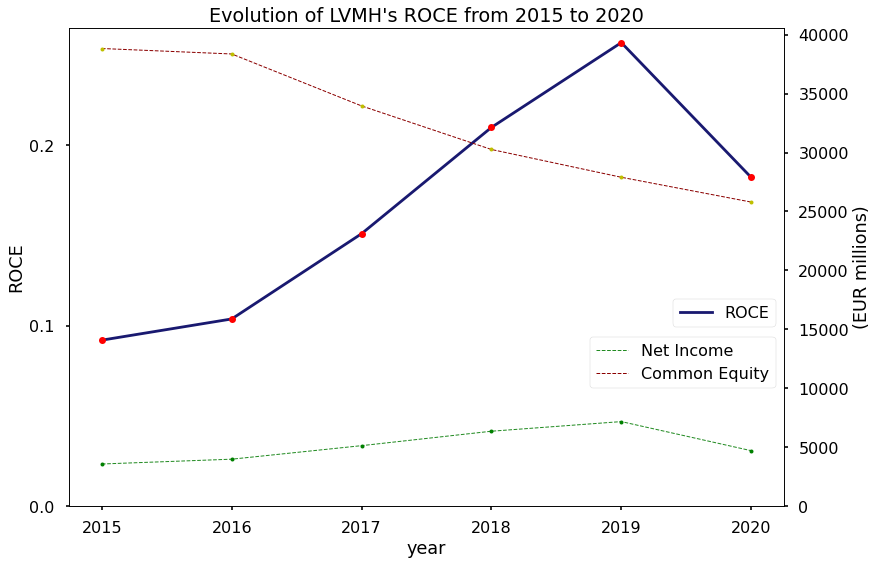

In [89]:
years.sort()
fig, ax1 = plt.subplots()

ax1.plot(years, ROCE, color='midnightblue', label='ROCE')
ax1.plot(years, ROCE, 'ro', markersize=7)

ax1.set_yticks(np.arange(0, (ROCE.max() + ROCE.max() * 0.1), step=0.1))
ax1.set_xlabel('year')
ax1.set_ylabel('ROCE')
ax1.legend(loc='upper right', bbox_to_anchor=(1, 0.45))

ax2 = ax1.twinx()
ax2.plot(years, net_income, linewidth=1, linestyle='dashed', color='forestgreen', label='Net Income')
ax2.plot(years, net_income, 'go', markersize=4)
ax2.plot(years, common_equity, linewidth=1, linestyle='dashed', color='darkred', label='Common Equity')
ax2.plot(years, common_equity, 'yo', markersize=4)

ax2.set_yticks(np.arange(0, (common_equity.max() + common_equity.max() * 0.1), step=5000))
ax2.set_ylabel('(EUR millions)')
ax2.legend(loc='lower right', bbox_to_anchor=(1, 0.23))

plt.title('Evolution of LVMH\'s ROCE from {} to {}'.format(years.min(), years.max()))
plt.savefig(fname='./plots/plot_ROCE', format='png')
plt.show()

### Disaggregating ROCE

In [ ]:
total_assets = assets.sum(axis=0).sort_index()
avg_assets = total_assets.rolling(window=2).mean()
avg_assets[2015] = total_assets[2015]

avg_equity = common_equity.sort_index().rolling(window=2).mean()
avg_equity[2015] = common_equity[2015]

adjusted_PM = net_income.sort_index() / sales
asset_turnover = sales / avg_assets
leverage = avg_assets / avg_equity

In [ ]:
leverage

In [ ]:
years.sort()
fig, ax1 = plt.subplots()

ax1.plot(years, asset_turnover, color='forestgreen', linewidth=2, label='Asset turnover')
ax1.plot(years, asset_turnover, 'go', markersize=5)
ax1.plot(years, adjusted_PM, color='midnightblue', linewidth=2, label='Adjusted profit margin')
ax1.plot(years, adjusted_PM, 'bo', markersize=5)
ax1.legend(loc='upper left', bbox_to_anchor=(0, 0.53))
ax1.set_xlabel('year')
ax1.set_ylabel('Asset turnover, Adjusted profit margin')

ax2 = ax1.twinx()
ax2.plot(years, leverage, color='darkred', linewidth=2, label='Leverage')
ax2.plot(years, leverage, 'ro', markersize=5)
ax2.legend(loc='upper left', bbox_to_anchor=(0, 0.6))
ax2.set_ylabel('Leverage')

plt.title('Dissagregation of LVMH\'s ROCE')
plt.savefig(fname='./plots/plot_Dissag-ROCE', format='png')
plt.show()

## Asset turnover

In [ ]:
# Data from other sources
# Apparel And Other Finished Products Made From Fabrics And Similar Materials Industry median ratios
# 2019->2015
median_ROA = pd.Series([0.078, 0.049, 0.028, 0.024, 0.053], index=years_median)
median_asset_turnover = pd.Series([1.162, 1.123, 1.181, 1.197, 1.337], index=years_median)

median_receivables_turnover = pd.Series([47, 37, 42, 38, 35], index=years_median)
median_days_sales_outstanding = 365 / median_receivables_turnover

median_days_sales_inventory = pd.Series([109, 118, 115, 115, 116], index=years_median)
median_inventory_turnover = 365 / median_days_sales_inventory

In [ ]:
accounts_receivables = balance_sheet.loc['Trade accounts receivable'].copy().sort_index()
avg_acc_receivables = accounts_receivables.rolling(window=2).mean()
avg_acc_receivables[2015] = accounts_receivables[2015]

acc_receivables_turnover = sales / avg_acc_receivables
days_sales_outstanding = 365 / acc_receivables_turnover

inventory = balance_sheet.loc['Inventories and work in progress'].copy().sort_index()
avg_inventory = inventory.rolling(window=2).mean()
avg_inventory[2015] = inventory[2015]

cogs = -income_statement.loc['COGS'].copy().sort_index()
inventory_turnover = cogs / avg_inventory
days_sales_inventory = 365 / inventory_turnover

In [ ]:
days_sales_inventory

In [ ]:
# plot_ratio(asset_turnover, years, 'Asset turnover')
# plot_ratio(acc_receivables_turnover, 'Accounts receivable turnover', median_receivables_turnover)
# plot_ratio(days_sales_outstanding, 'Days sales outstanding (days)', median_days_sales_outstanding)
# plot_ratio(inventory_turnover, 'Inventory turnover', median_inventory_turnover)
plot_ratio(days_sales_inventory, 'Days sales inventory (days)', median_days_sales_inventory)

In [ ]:
# asset_turnover
# acc_receivables_turnover
days_sales_outstanding
# inventory_turnover
# days_sales_inventory

### Computations for my colleague

In [ ]:
# current ratio
current_ratio = (total_current_assets / total_short_term_debt).sort_index()

#acid test ratio / quick ratio
total_acid_assets = current_assets.drop(['Inventories and work in progress', 'Income taxes (asset)']).sum(axis=0)
acid_test_ratio = (total_acid_assets / total_short_term_debt).sort_index()
acid_test_ratio.sort_index()

#cash flow ratio
operating_cash_flow = pd.Series([10897, 11648, 8490, 7030, 6239, 5634], index=years)
cash_flow_ratio = (operating_cash_flow / total_short_term_debt).sort_index()

# accounts payable turnover
accounts_payable = short_term_debt.loc['Trade accounts payable'].sort_index()
avg_accounts_payable = accounts_payable.rolling(window=2).mean()
avg_accounts_payable[2015] = accounts_payable[2015]

accounts_payable_turnover = cogs / avg_accounts_payable

# current assets turnover
avg_current_assets = total_current_assets.sort_index().rolling(window=2).mean()
avg_current_assets[2015] = total_current_assets[2015]
current_asset_turnover = sales / avg_current_assets

# gross profit margin
gross_profit_margin = income_statement.loc['Gross margin'].copy().sort_index() / sales

# operating profit margin
operating_profit_margin = income_statement.loc['Operating profit'].copy().sort_index() / sales

# net profit margin
net_profit_margin = income_statement.loc['Net profit, Group share'].copy().sort_index() / sales

In [ ]:
#Industry medians
current_ratio_industry_median = pd.Series([2.12, 1.99, 2.25, 2.31, 1.82], index=years_median)
acid_test_ratio_industry_median = pd.Series([1.13, 0.98, 1.15, 1.31, 1.17], index=years_median)
gross_profit_margin_industry_median = pd.Series([0.469, 0.458, 0.443, 0.45, 0.473], index=years_median)
operating_profit_margin_industry_median = pd.Series([0.061, 0.067, 0.045, 0.033, 0.084], index=years_median)
net_profit_margin_industry_median = pd.Series([0.065, 0.045, 0.036, 0.017, 0.047], index=years_median)

In [ ]:
# plot_ratio(current_ratio, 'current ratio', current_ratio_industry_median)
# plot_ratio(acid_test_ratio, 'acid-test ratio', acid_test_ratio_industry_median)
# plot_ratio(cash_flow_ratio, 'cash flow ratio')
# plot_ratio(accounts_payable_turnover, 'accounts payable turnover')
# plot_ratio(current_asset_turnover, 'current assets turnover')
# plot_ratio(gross_profit_margin, 'gross profit margin', gross_profit_margin_industry_median)
# plot_ratio(operating_profit_margin, 'operating profit margin', operating_profit_margin_industry_median)
# plot_ratio(net_profit_margin, 'net profit margin', net_profit_margin_industry_median)
